In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [3]:
df = pd.read_csv('data/klabin_historical.csv')

In [4]:
data = df[['Date', 'Close']]
data.head()

,Date,Close
0,2008-01-02 00:00:00-02:00,0.749389
1,2008-01-03 00:00:00-02:00,0.745956
2,2008-01-04 00:00:00-02:00,0.721930
3,2008-01-07 00:00:00-02:00,0.734515
4,2008-01-08 00:00:00-02:00,0.716209


In [5]:
# settando o cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

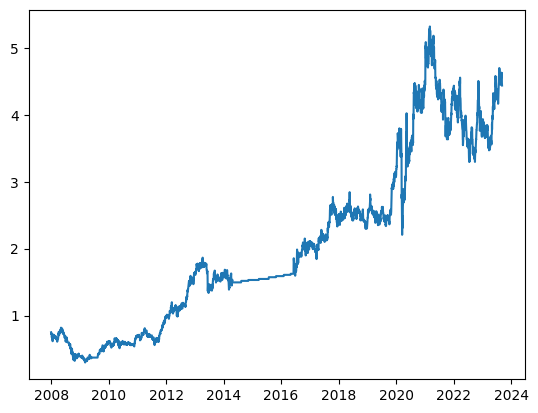

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data.loc[:, 'Date'], data.loc[:, 'Close']);

In [7]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2008-01-11 00:00:00-02:00,0.671589,0.687607,0.703625,0.716209,0.734515,0.721930,0.745956,0.749389
2008-01-14 00:00:00-02:00,0.701336,0.671589,0.687607,0.703625,0.716209,0.734515,0.721930,0.745956
2008-01-15 00:00:00-02:00,0.684175,0.701336,0.671589,0.687607,0.703625,0.716209,0.734515,0.721930
2008-01-16 00:00:00-02:00,0.692183,0.684175,0.701336,0.671589,0.687607,0.703625,0.716209,0.734515
2008-01-17 00:00:00-02:00,0.657860,0.692183,0.684175,0.701336,0.671589,0.687607,0.703625,0.716209


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[0.67158949, 0.68760699, 0.70362467, ..., 0.72193015, 0.74595642,
        0.74938869],
       [0.70133615, 0.67158949, 0.68760699, ..., 0.73451549, 0.72193015,
        0.74595642],
       [0.68417478, 0.70133615, 0.67158949, ..., 0.71620947, 0.73451549,
        0.72193015],
       ...,
       [4.61000013, 4.63000011, 4.5999999 , ..., 4.63000011, 4.57999992,
        4.53000021],
       [4.48000002, 4.61000013, 4.63000011, ..., 4.61000013, 4.63000011,
        4.57999992],
       [4.44000006, 4.48000002, 4.61000013, ..., 4.59000015, 4.61000013,
        4.63000011]])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.8511073 , -0.84473268, -0.83835799, ..., -0.8310728 ,
        -0.82151085, -0.82014488],
       [-0.83926877, -0.8511073 , -0.84473268, ..., -0.8260641 ,
        -0.8310728 , -0.82151085],
       [-0.84609863, -0.83926877, -0.8511073 , ..., -0.8333495 ,
        -0.8260641 , -0.8310728 ],
       ...,
       [ 0.71629628,  0.72425585,  0.71231641, ...,  0.72425585,
         0.70435684,  0.68445802],
       [ 0.66455901,  0.71629628,  0.72425585, ...,  0.71629628,
         0.72425585,  0.70435684],
       [ 0.64863987,  0.66455901,  0.71629628, ...,  0.70833672,
         0.71629628,  0.72425585]])

In [10]:
shifted_df_as_np.shape

(3888, 8)

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3888, 7), (3888,))

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-0.82014488, -0.82151085, -0.8310728 , ..., -0.8333495 ,
        -0.83835799, -0.84473268],
       [-0.82151085, -0.8310728 , -0.8260641 , ..., -0.83835799,
        -0.84473268, -0.8511073 ],
       [-0.8310728 , -0.8260641 , -0.8333495 , ..., -0.84473268,
        -0.8511073 , -0.83926877],
       ...,
       [ 0.68445802,  0.70435684,  0.72425585, ...,  0.70833672,
         0.71231641,  0.72425585],
       [ 0.70435684,  0.72425585,  0.71629628, ...,  0.71231641,
         0.72425585,  0.71629628],
       [ 0.72425585,  0.71629628,  0.70833672, ...,  0.72425585,
         0.71629628,  0.66455901]])

In [13]:
split_index = int(len(X) * 0.90)

split_index

3499

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3499, 7), (389, 7), (3499,), (389,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Aqui o shape significa: (profundidade: 15489, linhas: 7, colunas: 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3499, 7, 1), (389, 7, 1), (3499, 1), (389, 1))

In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3499, 7, 1]),
 torch.Size([389, 7, 1]),
 torch.Size([3499, 1]),
 torch.Size([389, 1]))

In [17]:
# Criando o objeto Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 8, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [30]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index + 1 % 100 == 0:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [31]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [32]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.001
***************************************************

Epoch: 2

Val Loss: 0.002
***************************************************

Epoch: 3

Val Loss: 0.002
***************************************************

Epoch: 4

Val Loss: 0.002
***************************************************

Epoch: 5

Val Loss: 0.001
***************************************************

Epoch: 6

Val Loss: 0.001
***************************************************

Epoch: 7

Val Loss: 0.002
***************************************************

Epoch: 8

Val Loss: 0.001
***************************************************

Epoch: 9

Val Loss: 0.001
***************************************************

Epoch: 10

Val Loss: 0.001
***************************************************



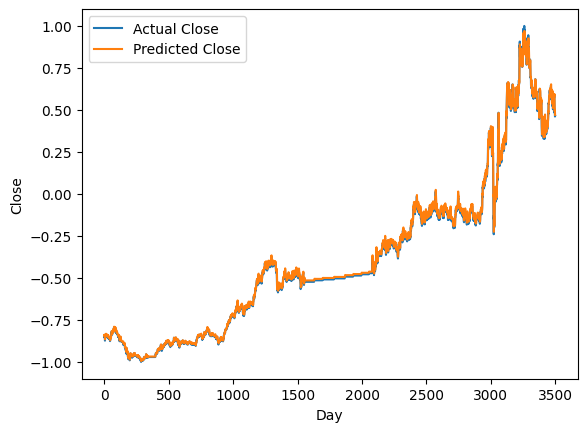

In [33]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [34]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([0.7011198 , 0.68487771, 0.70181847, ..., 4.0704963 , 4.0143616 ,
       3.99162555])

In [35]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([0.67158951, 0.70133621, 0.68417485, ..., 3.98571899, 3.9678466 ,
       3.97678283])

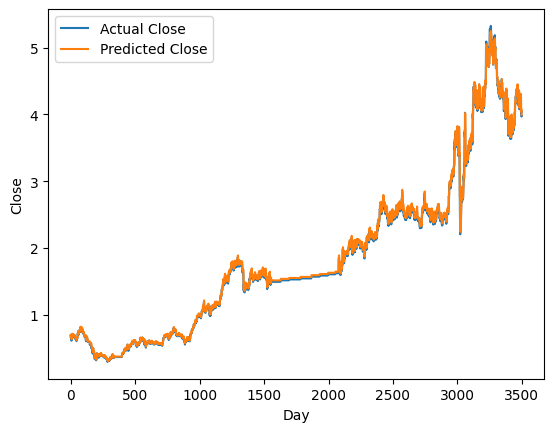

In [36]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [37]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([4.00070302, 4.01993418, 4.01374875, 4.05315372, 3.93302851,
       3.90805942, 3.9951526 , 3.98329693, 3.98570072, 4.14090543,
       4.17671746, 4.24542582, 4.25975147, 4.34476797, 4.39465343,
       4.34980932, 4.2353852 , 4.31157359, 4.40633867, 4.50934025,
       4.45748578, 4.52985538, 4.48751495, 4.55580276, 4.30400085,
       4.26043711, 4.25947919, 4.23892348, 4.18842516, 4.10079146,
       4.05983339, 4.01042074, 4.06597345, 4.00133864, 4.01589673,
       3.97090839, 3.93999469, 3.93902718, 3.94950513, 3.86715092,
       3.85702927, 3.84380352, 3.81837239, 3.79968818, 3.69698373,
       3.66102913, 3.66396669, 3.58216886, 3.62474833, 3.69442584,
       3.87539028, 3.93491319, 3.95569596, 3.83640226, 3.74192804,
       3.72101258, 3.70895173, 3.84686928, 3.85618652, 3.90798633,
       3.8955536 , 3.8648689 , 3.87845724, 3.91597243, 3.88609917,
       3.81178737, 3.87276094, 3.91009642, 3.90336492, 3.95057208,
       4.01470067, 4.00324069, 3.93011237, 3.92122271, 3.90744

In [38]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([3.99465657, 3.98571899, 4.03040359, 3.89635419, 3.88741728,
       3.97678283, 3.94997406, 3.95890976, 4.128705  , 4.14657836,
       4.2270079 , 4.23594383, 4.33424719, 4.37892955, 4.3253102 ,
       4.20913499, 4.30743744, 4.39680291, 4.50404175, 4.43254904,
       4.53085134, 4.46829607, 4.55766154, 4.26275343, 4.2538175 ,
       4.24488067, 4.21807092, 4.16445158, 4.07508566, 4.03933908,
       3.98571899, 4.04827591, 3.9678466 , 3.99465657, 3.9410367 ,
       3.91422725, 3.91422725, 3.92316319, 3.83379794, 3.83379794,
       3.81592465, 3.78911423, 3.77124139, 3.66400241, 3.63719296,
       3.63719296, 3.54782704, 3.60144661, 3.66400241, 3.851671  ,
       3.89635419, 3.92316319, 3.79884723, 3.7172489 , 3.69911576,
       3.68098308, 3.82604623, 3.81697962, 3.88044549, 3.86231258,
       3.83511261, 3.85324552, 3.88951157, 3.85324552, 3.78071477,
       3.85324552, 3.88044549, 3.87137866, 3.92577717, 3.98924259,
       3.97111013, 3.8985784 , 3.8985784 , 3.88044549, 3.83511

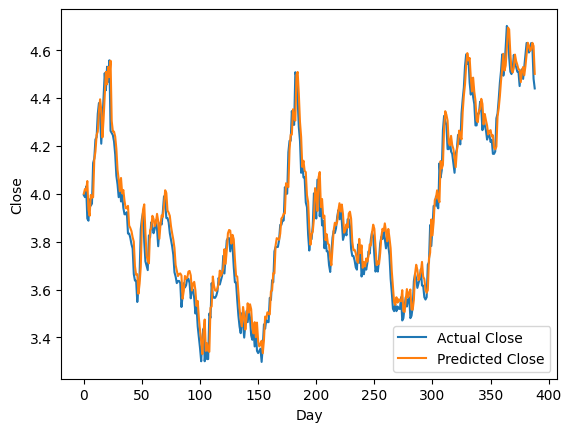

In [39]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()